# Moded code for BTL_AI - 75% code ported

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np # linear algebra

import os # path processing
from mnist import MNIST # mnist file reader
from time import perf_counter # timer
import pickle # save train model

## Load the data

In [8]:
file_loc = os.path.abspath('')

mnistdt = MNIST(file_loc +'./mnistdb')
img_arr_test, lb_arr_test = mnistdt.load_testing()
img_arr_train, lb_arr_train = mnistdt.load_training()

## Init the data and-pre processing It

### reusueable funtions to prepare the data

In [10]:
# image view
def resize(img):
    return np.reshape(img, [-1, 28, 28, 1])

def image_show(a):
    some_digit = a
    some_digit_image = some_digit.reshape(28,28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")

# data fomater
def normalize(X):
    return X/255

def onehot_encoding(y):
    return np.eye(np.max(y)+1)[y]

# def add_bias(X):
#     return np.insert(X, 0, 1, axis=1)

### pre-processing data

In [14]:
# Image array to take a look
img_test = resize(img_arr_test)
img_train = resize(img_arr_train)

# ds organized
X_train =  normalize(np.array(img_arr_train))
X_test = normalize(np.array(img_arr_test))
y_train = np.array(lb_arr_train)
y_test = np.array(lb_arr_test)

# subsample
X_ss100_train = X_train [100:200]
X_ss100_test = X_test [100:200]
y_ss100_train = y_train [100:200]
y_ss100_test = y_test [100:200]

X_ss1000_train = X_train [1000:2000]
X_ss1000_test = X_test [1000:2000]
y_ss1000_train = y_train [1000:2000]
y_ss1000_test = y_test [1000:2000]


## Data classification

### Softmax 

In [6]:
class MultiClassLogisticRegression:
    
    def __init__(self, n_iter, lr, i_Acc):
        self.n_iter = n_iter     #Vong lap
        self.isBreak =  0.0001     #do chenh lenh dung
        self.lr =  lr  #Learning rate
        self.i_Acc = i_Acc

    def fit(self, X, y, X_val, y_val): 
        self.classes = np.unique(y)   #lay ra all cac du lieu khac nhau cua y giong nhu set
        self.class_labels = {c:i for i,c in enumerate(self.classes)}   #dan nhan cho tuong class
        X, y = self.ADCT(X, y)  #CT trong giao trinh
        X_val, y_val = self.ADCT(X_val, y_val)
        self.loss_train = []
        self.error_train = []
        self.loss_test = [] 
        self.error_test = []
        self.weights = np.zeros(shape=(len(self.classes),X.shape[1]))  #(10x784) 
        self.gradient_descent(X, y,  X_val, y_val)
        return self
    
    def ADCT(self, x, y):
        x = self.add_bias(x)  #CT trong giao trinh
        y = self.one_hot(y)   #CT trong giao trinh
        return x, y
 
    def gradient_descent(self, X, y, X_val, y_val):
          start = perf_counter()
          j = 0
          for i in range(self.n_iter):
            
            self.multinomial_logreg_error(X, y, X_val, y_val)
            update = self.multinomial_logreg_grad_i(X, y)
            self.weights += update
            if np.abs(update).max() < self.isBreak: 
                break
            if i % self.i_Acc == 0: 
                
                message = 'Loop {},  Loss_train {},  Acc_train {}, Loss_test {}, Acc_test {}'.format(i+1,self.loss_train[i], self.error_train[i], self.loss_test[i], self.error_test[i])
                j += 1
                print(message)
          end = perf_counter()
          time = int(end) - int(start)
          print('Chuong trinh chay mat: {} s'.format(time))
     
    def multinomial_logreg_error(self, X, y, X_val, y_val):
          self.loss_train.append(self.multinomial_logreg_loss_i(y, self.predict(X)))
          self.error_train.append(self.evaluate(X, y))
          self.loss_test.append(self.multinomial_logreg_loss_i(y_val, self.predict(X_val)))
          self.error_test.append(self.evaluate(X_val, y_val))
    
    def predict(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def CheckModel(self, X, number):
        print('Dự đoán cua X_test[{}] la: {}'.format(number, self.predict_class(X)[number]))
        
        plt.imshow(X_test[number].reshape(28,28), cmap='gray')
        plt.show()

    def predict_class(self, X):
        X_add = self.predict(self.add_bias(X))   #Xac suat
        return np.argmax(X_add, axis=1)

    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
  
    def one_hot(self, y):
        return np.eye(len(self.classes))[(y).reshape(-1)]
    
    def evaluate(self, X, y):
        return np.mean(np.argmax(self.predict(X), axis=1) == np.argmax(y, axis=1))
    
    #cross_entropy
    def multinomial_logreg_loss_i(self, y, probs):
        return -(np.mean(y * np.log(probs)))

    def score(self, X, y):
        return np.mean(self.predict_class(X) == y)

    def multinomial_logreg_grad_i(self, X, y):
        error = y - self.predict(X)
        return (self.lr * np.dot(error.T, X))

## Json Object Storage System

## test save file with pickle

In [2]:
# save the model to disk
def save_model(obj, filename):
    filename = os.path.join(os.path.abspath('./pretrain_models/'), filename + ".sav")
    pickle_file = open(filename, 'wb')
    pickle.dump(obj, pickle_file)
    pickle_file.close()

def load_model(filename):
    file_path = os.path.join(os.path.abspath('./pretrain_models/'), filename)
    loaded_model = pickle.load(open(file_path, 'rb'))
    return loaded_model

In [15]:
lr_100 = MultiClassLogisticRegression(100, 0.0001, 10)
lr_100.fit(X_train,y_train, X_test, y_test)

# save model 100
save_model(lr_100, "lr100")

Loop 1,  Loss_train 0.23025850929940458,  Acc_train 0.098, Loss_test 0.23025850929940433, Acc_test 0.09871666666666666
Loop 11,  Loss_train 0.09274982761646215,  Acc_train 0.777, Loss_test 0.09684620923464225, Acc_test 0.7626166666666667
Loop 21,  Loss_train 0.056027020742564576,  Acc_train 0.8204, Loss_test 0.06150368228517593, Acc_test 0.8010166666666667
Loop 31,  Loss_train 0.0407000981757175,  Acc_train 0.8819, Loss_test 0.046663963116460996, Acc_test 0.8622666666666666
Loop 41,  Loss_train 0.03605998136829538,  Acc_train 0.9008, Loss_test 0.04217300165728041, Acc_test 0.8807
Loop 51,  Loss_train 0.034307440230928854,  Acc_train 0.9051, Loss_test 0.04064327421577704, Acc_test 0.8858
Loop 61,  Loss_train 0.03301145487070379,  Acc_train 0.9095, Loss_test 0.03957250755087033, Acc_test 0.8887833333333334
Loop 71,  Loss_train 0.031970935836651164,  Acc_train 0.9117, Loss_test 0.03874499329487194, Acc_test 0.8910166666666667
Loop 81,  Loss_train 0.03110615118640057,  Acc_train 0.9141, Lo

In [ ]:
lr_100.CheckModel(X_test, 23)
lr_100.score(X_test, y_test)

Dự đoán cua X_test[200] la: 1


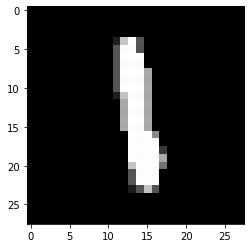

0.8949333333333334

In [13]:
# test saved model
test_sav_100 = load_model("lr100.sav")
test_sav_100.CheckModel(X_test, 200)
test_sav_100.score(X_test, y_test)

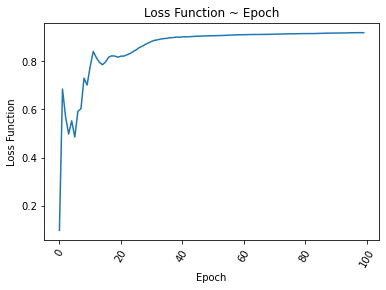

In [10]:
def plot(loss_list):
    """store the plots"""
    # epoch_list = list(range(len(loss_list)))
    plt.plot(loss_list)
    plt.ylabel('Loss Function')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Loss Function ~ Epoch')
    plt.show()

plot(lr_100.error_train)

# Run configuration:

In [22]:
lr_ss100 = MultiClassLogisticRegression(1000, 0.0001, 10)
lr_ss100.fit(X_ss100_train,y_ss100_train, X_ss100_test, y_ss100_test)

save_model(lr_ss100, "lr_ss100")

Loop 1,  Loss_train 0.23025850929940453,  Acc_train 0.09, Loss_test 0.23025850929940453, Acc_test 0.08
Loop 11,  Loss_train 0.21493748309254243,  Acc_train 0.55, Loss_test 0.22266681167007873, Acc_test 0.32
Loop 21,  Loss_train 0.20144639941117906,  Acc_train 0.63, Loss_test 0.2157168455755439, Acc_test 0.42
Loop 31,  Loss_train 0.1893153806219592,  Acc_train 0.68, Loss_test 0.209215354505479, Acc_test 0.44
Loop 41,  Loss_train 0.1782973478332013,  Acc_train 0.73, Loss_test 0.20311541345050688, Acc_test 0.44
Loop 51,  Loss_train 0.16824579028481615,  Acc_train 0.8, Loss_test 0.19741431114950206, Acc_test 0.46
Loop 61,  Loss_train 0.15905826754888205,  Acc_train 0.81, Loss_test 0.19211293356852235, Acc_test 0.48
Loop 71,  Loss_train 0.15065147490645636,  Acc_train 0.82, Loss_test 0.18720357781988667, Acc_test 0.5
Loop 81,  Loss_train 0.14295142600561453,  Acc_train 0.84, Loss_test 0.1826693628989736, Acc_test 0.49
Loop 91,  Loss_train 0.1358902539270929,  Acc_train 0.87, Loss_test 0.178

In [23]:
lr_ss1000 = MultiClassLogisticRegression(1000, 0.0001, 10)
lr_ss1000.fit(X_ss1000_train,y_ss1000_train, X_ss1000_test, y_ss1000_test)

save_model(lr_ss1000, "lr_ss1000") 

Loop 1,  Loss_train 0.23025850929940456,  Acc_train 0.09, Loss_test 0.23025850929940456, Acc_test 0.094
Loop 11,  Loss_train 0.1594437975647607,  Acc_train 0.763, Loss_test 0.16287670719973577, Acc_test 0.744
Loop 21,  Loss_train 0.12364674225474694,  Acc_train 0.792, Loss_test 0.12934719059064884, Acc_test 0.758
Loop 31,  Loss_train 0.10389200797603271,  Acc_train 0.817, Loss_test 0.11124593421498885, Acc_test 0.767
Loop 41,  Loss_train 0.09160588920155106,  Acc_train 0.832, Loss_test 0.10024519566624412, Acc_test 0.776
Loop 51,  Loss_train 0.0831957103285672,  Acc_train 0.839, Loss_test 0.0928861207361523, Acc_test 0.784
Loop 61,  Loss_train 0.07701827652850346,  Acc_train 0.845, Loss_test 0.08760468038737854, Acc_test 0.791
Loop 71,  Loss_train 0.07223954973091545,  Acc_train 0.846, Loss_test 0.08361565600613728, Acc_test 0.796
Loop 81,  Loss_train 0.06839631673612324,  Acc_train 0.85, Loss_test 0.08048694561956815, Acc_test 0.797
Loop 91,  Loss_train 0.06521173455388958,  Acc_train